## Part VIII.I - Custom Model Registration, Governance, and Deployment

University of San Diego - MS Applied AI

AAI-540 Team 5

October 21, 2024

### Setup

In [2]:
# Setup environment
%run 0-Environment_Setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


In [3]:
# Import model card libraries
from sagemaker.model_card import (
    ModelCard,
    ModelOverview,
    ObjectiveFunction,
    Function,
    TrainingDetails,
    TrainingJobDetails,
    IntendedUses,
    BusinessDetails,
    EvaluationJob,
    AdditionalInformation,
    Metric,
    MetricGroup,
    ModelCardStatusEnum,
    ObjectiveFunctionEnum,
    FacetEnum,
    RiskRatingEnum,
    MetricTypeEnum,
    EvaluationMetricTypeEnum,
    HyperParameter
)

from sagemaker.transformer import Transformer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [4]:
# Set session variables
sm_client = boto3.client('sagemaker', region_name=region)
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_session.region_name
bucket = sess.default_bucket()

train_prefix = "store-sales-forecasting/train"
test_prefix = "store-sales-forecasting/test"
val_prefix = "store-sales-forecasting/val"
transform_input_prefix = "store-sales-forecasting/transform-input"
transform_output_prefix = "store-sales-forecasting/transform-output"

### Load the most recently trained model

In [ ]:
# Get most recent model info
model_name = sm_client.list_models()['Models'][0]['ModelName']
model_info = sm_client.describe_model(ModelName=model_name)
model_container = {
    "Image": model_info['PrimaryContainer']['Image'],
    "ModelDataUrl": model_info['PrimaryContainer']['ModelDataUrl']
}

### Generate batch predictions

In [7]:
# Configure a transformer for the model
transformer = Transformer(
    model_name=model_name,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=f's3://{bucket}/{transform_output_prefix}',
    accept="application/jsonlines"
)

In [8]:
# Run a batch transform job
transformer.transform(
    data=f"s3://{bucket}/{transform_input_prefix}",
    content_type="application/jsonlines",
    split_type="Line"
)

transformer.wait()

INFO:sagemaker:Creating transform job with name: tensorflow-inference-2024-10-19-03-17-05-133


...............................INFO:__main__:PYTHON SERVICE: False
INFO:__main__:starting services
INFO:__main__:using default model name: model
INFO:__main__:tensorflow serving model config: 
model_config_list: {
  config: {
    name: 'model'
    base_path: '/opt/ml/model'
    model_platform: 'tensorflow'
    model_version_policy: {
      specific: {
        versions: 1
      }
    }
  }
}
INFO:__main__:tensorflow version info:
2024-10-19 03:22:10.794501: W external/org_tensorflow/tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-19 03:22:10.794600: W external/org_tensorflow/tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
TensorFlow ModelServer: 2.6.0-rc2+dev.sha.dca3641
TensorFlow Library: 2.6.0
INFO:__main__:tensorflow serving command: tensorflow_model_server --port=10000 --rest_api_port=1000

### Evaluate the batch transform job

In [9]:
# Download predictions from the batch transform job and true labels and normalization statistics
transform_results_local_path = "transform-results/"
val_targets_path = f"s3://{sagemaker_session.default_bucket()}/{val_prefix}/val_targets.npy"
global_mean_path = f"s3://{sagemaker_session.default_bucket()}/{train_prefix}/global_mean.npy"
global_stddev_path = f"s3://{sagemaker_session.default_bucket()}/{train_prefix}/global_stddev.npy"

!aws s3 cp $val_targets_path $transform_results_local_path
!aws s3 cp $global_mean_path $transform_results_local_path
!aws s3 cp $global_stddev_path $transform_results_local_path
sagemaker_session.download_data(path=transform_results_local_path, bucket=bucket, key_prefix=transform_output_prefix)

download: s3://sagemaker-us-east-1-342408968837/store-sales-forecasting/val/val_targets.npy to transform-results/val_targets.npy
download: s3://sagemaker-us-east-1-342408968837/store-sales-forecasting/train/global_mean.npy to transform-results/global_mean.npy
download: s3://sagemaker-us-east-1-342408968837/store-sales-forecasting/train/global_stddev.npy to transform-results/global_stddev.npy


['transform-results/validation_data.ndjson.out',
 'transform-results/../transform-outputs/validation_data.ndjson.out']

In [10]:
# Load npy objects
val_targets = np.load(os.path.join(transform_results_local_path, 'val_targets.npy'))
global_mean = np.load(os.path.join(transform_results_local_path, 'global_mean.npy'))
global_stddev = np.load(os.path.join(transform_results_local_path, 'global_stddev.npy'))

print(val_targets.shape)
print(global_mean)
print(global_stddev)

(162, 54, 1)
[11066.08424029    72.62890566    23.37328494]
[9928.63142484   26.6484683    43.2551771 ]


In [11]:
# Deserialize the batch transform predictions
import json

with open("transform-results/validation_data.ndjson.out", "r") as f:
    predictions = []
    for line in f:
        obj = json.loads(line.strip())
        predictions.extend(obj["predictions"])

predictions_array = np.array(predictions)
print(predictions_array.shape)

(162, 54, 1)


In [12]:
# Compute RMSE and MAE on the normalized scale
targets_flat = val_targets.flatten()
predictions_flat = predictions_array.flatten()

rmse = root_mean_squared_error(targets_flat, predictions_flat)
mae = mean_absolute_error(targets_flat, predictions_flat)
print(f"RMSE: {rmse} MAE: {mae}")


RMSE: 0.6838335057629742 MAE: 0.36826900349306524


In [13]:
# Create a baseline dataframe from the normalized predictions
n = predictions_array.shape[0]
store_numbers = list(range(54)) * n
baseline_df = pd.DataFrame({'store_nbr': store_numbers, 'actual_sales': targets_flat, 'predicted_sales': predictions_flat})

# Write out baseline dataframe
baseline_path = f"{transform_results_local_path}/baseline.csv"
baseline_df.to_csv(baseline_path, index=False)

# Upload to S3
sagemaker_session.upload_data(path=baseline_path, bucket=bucket, key_prefix="store-sales-forecasting/baseline")

's3://sagemaker-us-east-1-342408968837/store-sales-forecasting/baseline/baseline.csv'

In [14]:
# Denormalize to the original scale of the data
targets_denormalized = val_targets * global_stddev[0] + global_mean[0]
predictions_denormalized = predictions_array * global_stddev[0] + global_mean[0]

targets_flat = targets_denormalized.flatten()
predictions_flat = predictions_denormalized.flatten()

# Join the predictions and actual sales values for each store/date into a dataframe
n = predictions_denormalized.shape[0]
store_numbers = list(range(54)) * n
predictions_df = pd.DataFrame({'store_nbr': store_numbers, 'actual_sales': targets_flat, 'predicted_sales': predictions_flat})

# View a random sample of 20 predicted vs actual sales values
display(predictions_df.sample(20))

# Compute RMSE and MAE on the original scale
rmse = root_mean_squared_error(targets_flat, predictions_flat)
mae = mean_absolute_error(targets_flat, predictions_flat)
print(f"RMSE: {rmse} MAE: {mae}")

,store_nbr,actual_sales,predicted_sales
3249,9,8137.035082,8401.406019
1694,20,12838.693207,8891.884572
1471,13,6352.217136,7548.695984
3922,34,2343.373616,5791.839666
4528,46,29047.666390,31156.584344
6894,36,17305.226985,14551.450009
5403,3,11992.258715,12582.305273
5768,44,38015.757223,33420.993611
4379,5,20250.667230,23456.006914
6328,10,30775.207545,23859.602306


RMSE: 6789.530834674811 MAE: 3656.407200874704


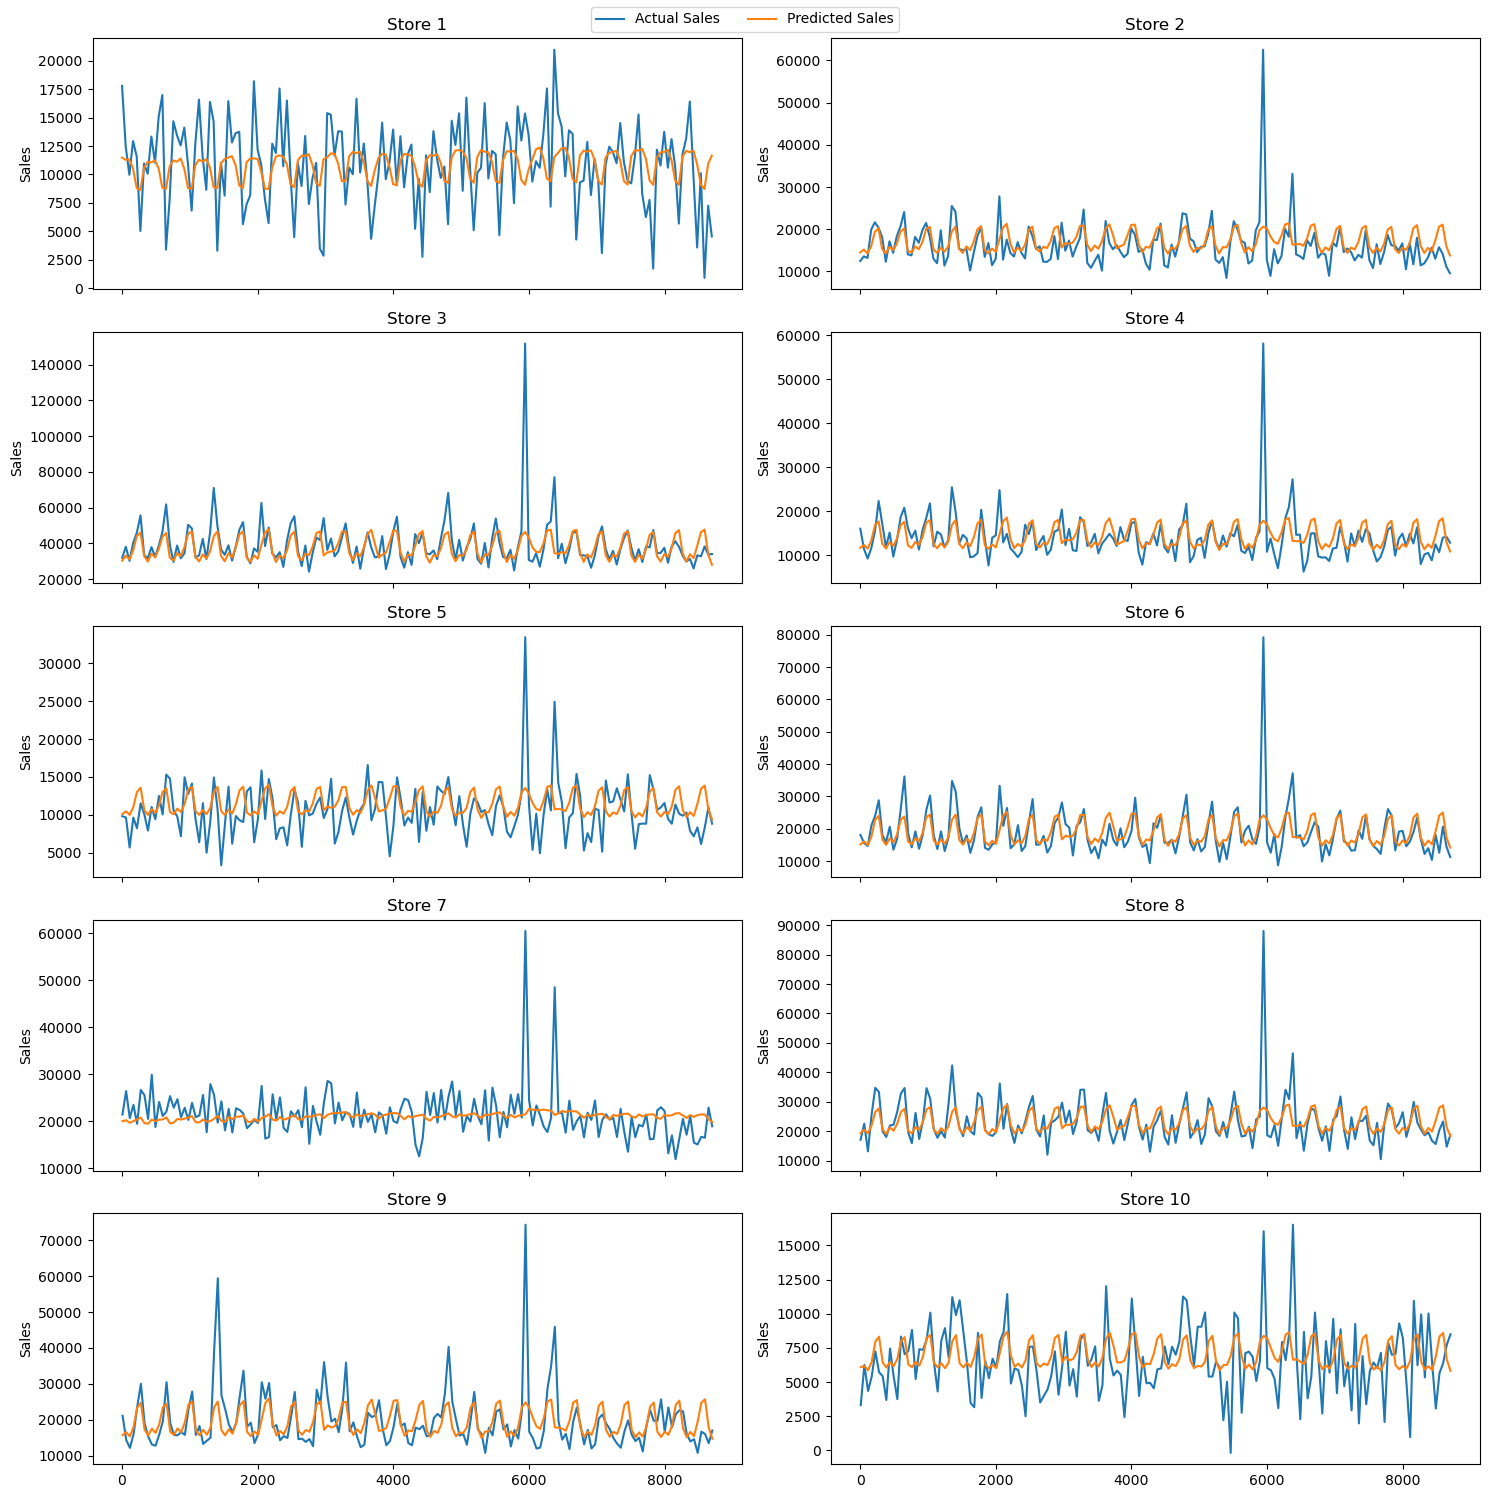

In [17]:
# Plot predictions for the first 10 stores
fig, axs = plt.subplots(5, 2, figsize=(15, 15), sharex=True)
axs = axs.ravel()
for i in range(10):
    ax = axs[i]
    store_data = predictions_df[predictions_df["store_nbr"] == i]

    ax.plot(store_data.index, store_data['actual_sales'], label='Actual Sales')
    ax.plot(store_data.index, store_data['predicted_sales'], label='Predicted Sales')

    ax.set_title(f"Store {i+1}")
    ax.set_ylabel("Sales")

fig.legend(['Actual Sales', 'Predicted Sales'], loc='upper center', ncol=2)
plt.tight_layout()
plt.show()

### Register the model

In [107]:
# Define and create model group
model_package_group_name = "store-sales-forecasting-custom-model-group"
model_package_group_input_dict = {
 "ModelPackageGroupName" : model_package_group_name,
 "ModelPackageGroupDescription" : "This model group contains time series forecasting models for predicting store sales for 54 Favorita stores."
}

create_model_package_group_response = sm_client.create_model_package_group(**model_package_group_input_dict)
print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))

# Check that the model group was created
describe_model_package_group_response = sm_client.describe_model_package_group(ModelPackageGroupName=model_package_group_name)
describe_model_package_group_response 

ModelPackageGroup Arn : arn:aws:sagemaker:us-east-1:342408968837:model-package-group/store-sales-forecasting-custom-model-group


{'ModelPackageGroupName': 'store-sales-forecasting-custom-model-group',
 'ModelPackageGroupArn': 'arn:aws:sagemaker:us-east-1:342408968837:model-package-group/store-sales-forecasting-custom-model-group',
 'ModelPackageGroupDescription': 'This model group contains time series forecasting models for predicting store sales for 54 Favorita stores.',
 'CreationTime': datetime.datetime(2024, 10, 15, 7, 17, 16, 785000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:342408968837:user-profile/d-2cr7fbmrqyrg/jlawton',
  'UserProfileName': 'jlawton',
  'DomainId': 'd-2cr7fbmrqyrg',
  'IamIdentity': {'Arn': 'arn:aws:sts::342408968837:assumed-role/LabRole/SageMaker',
   'PrincipalId': 'AROAU7OJKHKCWCCLLHI6O:SageMaker'}},
 'ModelPackageGroupStatus': 'Completed',
 'ResponseMetadata': {'RequestId': 'e1638ad0-0f8f-4448-b3bc-ca1c854d1b44',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e1638ad0-0f8f-4448-b3bc-ca1c854d1b44',
   'content-type': 'applicati

In [110]:
model_container

{'Image': '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.6-cpu',
 'Mode': 'SingleModel',
 'ModelDataUrl': 's3://sagemaker-us-east-1-342408968837/store-sales-forecasting/training-output/tensorflow-training-2024-10-15-05-41-38-410/output/model.tar.gz',
 'ModelDataSource': {'S3DataSource': {'S3Uri': 's3://sagemaker-us-east-1-342408968837/store-sales-forecasting/training-output/tensorflow-training-2024-10-15-05-41-38-410/output/model.tar.gz',
   'S3DataType': 'S3Object',
   'CompressionType': 'Gzip'}},
 'Environment': {'SAGEMAKER_TFS_NGINX_LOGLEVEL': 'info'}}

In [117]:
# Specify the model container
modelpackage_inference_specification =  {
    "InferenceSpecification": {
        "Containers": [model_container],
        "SupportedContentTypes": [ "text/csv" ],
        "SupportedResponseMIMETypes": [ "text/csv" ],
      
    }
 }

# Specify package details
create_model_package_input_dict = {
    "ModelPackageGroupName" : model_package_group_name,
    "ModelPackageDescription" : "Custom store sales forecasting model using CNN-GRU architecture",
    "ModelApprovalStatus" : "PendingManualApproval"
}
create_model_package_input_dict.update(modelpackage_inference_specification)

In [118]:
# Create the model package
create_model_package_response = sm_client.create_model_package(**create_model_package_input_dict)
model_package_arn = create_model_package_response["ModelPackageArn"]
print('ModelPackage Version ARN : {}'.format(model_package_arn))

# Check that the model package was created
describe_model_package_response = sm_client.describe_model_package(ModelPackageName=model_package_arn)
describe_model_package_response

ModelPackage Version ARN : arn:aws:sagemaker:us-east-1:342408968837:model-package/store-sales-forecasting-custom-model-group/1


{'ModelPackageGroupName': 'store-sales-forecasting-custom-model-group',
 'ModelPackageVersion': 1,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:342408968837:model-package/store-sales-forecasting-custom-model-group/1',
 'ModelPackageDescription': 'Custom store sales forecasting model using CNN-GRU architecture',
 'CreationTime': datetime.datetime(2024, 10, 15, 7, 24, 21, 721000, tzinfo=tzlocal()),
 'InferenceSpecification': {'Containers': [{'Image': '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.6-cpu',
    'ImageDigest': 'sha256:de3fd33aa1fa3225474fced65a5ed5bdcdce841319b517697d080b37ff5bacce',
    'ModelDataUrl': 's3://sagemaker-us-east-1-342408968837/store-sales-forecasting/training-output/tensorflow-training-2024-10-15-05-41-38-410/output/model.tar.gz'}],
  'SupportedContentTypes': ['text/csv'],
  'SupportedResponseMIMETypes': ['text/csv']},
 'ModelPackageStatus': 'Completed',
 'ModelPackageStatusDetails': {'ValidationStatuses': [],
  'ImageScanStatuses': [

### Create a model card

In [119]:
# Define model overview
model_overview = ModelOverview.from_model_name(
    model_name=model_name,
    sagemaker_session=sagemaker_session,
    model_description="Model to predict store sales for 54 Favorita stores based on historical sales data, oil prices, and seasonal information.",
    problem_type="Time Series Forecasting",
    algorithm_type="CNN-GRU",
    model_creator="AAI 540 Team 5",
    model_owner="AAI 540 Team 5",
)

In [124]:
# Define objective funtion
objective_function = ObjectiveFunction(
    function=Function(
        function=ObjectiveFunctionEnum.MINIMIZE,
        facet=FacetEnum.LOSS,
    ),
    notes="The model optimizes for mean squared error during training.",
)

# Get hyperparameters from the training job
model_training_job_name = model_info['PrimaryContainer']['ModelDataUrl'].split('/')[-3]
job = sm_client.describe_training_job(TrainingJobName=model_training_job_name)
hyperparameters = [HyperParameter(key, value) for key, value in job['HyperParameters'].items()]

# Create job details to include the hyperparameters in the training details
training_job_details = TrainingJobDetails(
    hyper_parameters=hyperparameters
)

# Define and view training details
training_details = TrainingDetails.from_model_overview(
    model_overview=model_overview,
    sagemaker_session=sagemaker_session,
    objective_function=objective_function,
    training_job_details=training_job_details
)
print(f"Training job id: {training_details.training_job_details.training_arn}")
print(
    f"Training image: {training_details.training_job_details.training_environment.container_image}"
)
print("Training Metrics: ")
print(
    [
        {"name": i.name, "value": i.value}
        for i in training_details.training_job_details.training_metrics
    ]
)

Training job id: arn:aws:sagemaker:us-east-1:342408968837:training-job/tensorflow-training-2024-10-15-05-41-38-410
Training image: ['763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.6-cpu-py38']
Training Metrics: 
[{'name': 'loss', 'value': 0.4708000123500824}, {'name': 'root_mean_squared_error', 'value': 0.6825000047683716}, {'name': 'mean_absolute_error', 'value': 0.36809998750686646}, {'name': 'val_loss', 'value': 0.36169999837875366}, {'name': 'val_root_mean_squared_error', 'value': 0.597000002861023}, {'name': 'val_mean_absolute_error', 'value': 0.36320000886917114}, {'name': 'epoch', 'value': 19.0}]


In [125]:
# Define intended uses and business_details
intended_uses = IntendedUses(
    purpose_of_model="This model is designed to forecast store sales for Favorita stores.",
    intended_uses="This model is intended to forecast sales for the 54 currently operational Favorita stores.",
    factors_affecting_model_efficiency="N/A",
    risk_rating=RiskRatingEnum.LOW,
    explanations_for_risk_rating="No PII or other sensitive information is used in this model.",
)
business_details = BusinessDetails(
    business_problem="Predicting Favorita store sales.",
    business_stakeholders="Favorita store managers, owners, and stakeholders.",
    line_of_business="Sales",
)

In [127]:
# Create the model card
model_card_name = "store-sales-forecasting-custom-model-card"
model_card = ModelCard(
    name=model_card_name,
    status=ModelCardStatusEnum.DRAFT,
    model_overview=model_overview,
    training_details=training_details,
    intended_uses=intended_uses,
    business_details=business_details,
    sagemaker_session=sagemaker_session,
)
model_card.create()
print(f"Model card {model_card.name} is successfully created with id {model_card.arn}")

INFO:sagemaker.model_card.model_card:Creating model card with name: store-sales-forecasting-custom-model-card


Model card store-sales-forecasting-custom-model-card is successfully created with id arn:aws:sagemaker:us-east-1:342408968837:model-card/store-sales-forecasting-custom-model-card


In [128]:
# Export the model card as a PDF and store in S3
s3_output_path = f"s3://{bucket}/store-sales-forecasting/export"
pdf_s3_url = model_card.export_pdf(s3_output_path=s3_output_path)

INFO:sagemaker.model_card.model_card:Model card store-sales-forecasting-custom-model-card is successfully exported to s3://sagemaker-us-east-1-342408968837/store-sales-forecasting/export/store-sales-forecasting-custom-model-card/store-sales-forecasting-custom-model-card-1728977351-d496.pdf.
